In [ ]:
import triton
import triton.language as tl
import torch

### Compute Kernel

In [ ]:
@triton.jit
def add_kernel(a_ptr, 
               b_ptr, 
               c_ptr,
               n_elements,
               BLOCK_SIZE: tl.constexpr,
               ):
    pid = tl.program_id(0)

    block_start  = pid * BLOCK_SIZE
    offsets      = block_start + tl.arange(0, BLOCK_SIZE)
    offsets_mask = offsets < n_elements

    a_vals = tl.load(a_ptr + offsets, mask=offsets_mask)
    b_vals = tl.load(b_ptr + offsets, mask=offsets_mask)
    
    tl.store(c_ptr + offsets, a_vals+b_vals, mask=offsets_mask)

### Setup function

In [ ]:
def add(a: torch.Tensor, b: torch.Tensor) -> torch.Tensor:
    c = torch.empty_like(a)
    n_elems = c.numel()

    grid = lambda meta: (triton.cdiv(n_elems, meta["BLOCK_SIZE"]), )
    add_kernel[grid](a, b, c, n_elems, BLOCK_SIZE=1024)

    return c

### Unit test

In [11]:
device = triton.runtime.driver.active.get_active_torch_device()

a = torch.randn(4096, device=device)
b = torch.randn(4096, device=device)

c1 = add(a, b)
c2 = a + b

torch.testing.assert_close(c1, c2)

### Benchmark

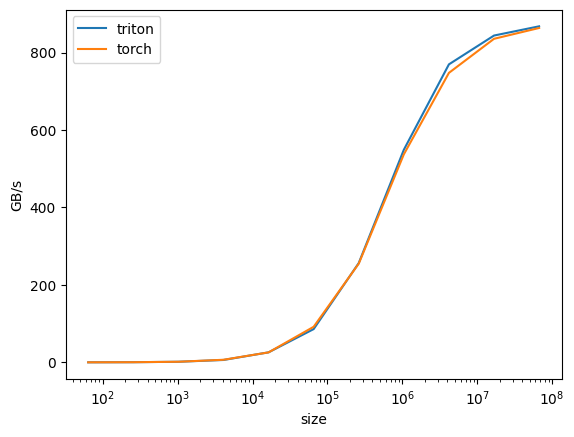

Triton vs. Torch:
          size      triton       torch
0         64.0    0.072629    0.089964
1        256.0    0.360625    0.358868
2       1024.0    1.531585    1.545849
3       4096.0    6.125367    6.655879
4      16384.0   25.827509   25.735484
5      65536.0   85.861554   91.820843
6     262144.0  256.354967  254.840610
7    1048576.0  548.883356  537.031787
8    4194304.0  769.416261  747.414033
9   16777216.0  843.807380  835.379107
10  67108864.0  867.615758  863.338761


In [18]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names    = ["size"],
        x_vals     = [2**i for i in range(6, 28, 2)],
        x_log      = True,
        line_arg   = "provider",
        line_vals  = ["triton", "torch"],
        line_names = ["triton", "torch"],
        ylabel     = 'GB/s',
        plot_name  = "Triton vs. Torch",
        args       = {} 
    )
)
def benchmark(size, provider):
    a = torch.randn(size, device=device, dtype=torch.float16)
    b = torch.randn(size, device=device, dtype=torch.float16)

    if provider == "triton":
        mean_ms = triton.testing.do_bench(lambda: add(a, b))
    else:
        mean_ms = triton.testing.do_bench(lambda: a + b)
    
    return (3 * a.numel() * a.element_size() * 1e-9) / (mean_ms * 1e-3)

benchmark.run(print_data=True, show_plots=True)